In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import stats
from scipy.optimize import minimize
import emcee
import numdifftools as nd

In [64]:
global_confirmed = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
global_deaths = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
global_recovered = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [65]:
us_confirmed = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/covid/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [40]:
def get_us_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:]  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:]  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])

    return pd.concat([confirmed,deaths], axis=1)

    

In [41]:
def get_data(country):
    df = global_confirmed[global_confirmed['Country/Region'] == country]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[4:]  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = global_deaths[global_deaths['Country/Region'] == country]
    deaths = df.sum(axis=0)
    deaths = deaths[4:]  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])

    df = global_recovered[global_recovered['Country/Region'] == country]
    recovered = df.sum(axis=0)
    recovered = recovered[4:]  # skip metadata
    recovered = pd.DataFrame(recovered,columns=['recovered'])
    
    return pd.concat([confirmed, recovered,deaths], axis=1)


In [42]:
# Let's fit USA data first
country = get_us_data('Colorado')
time = np.arange(len(country))
N = 5.759e6

In [66]:

def SEIR(t,y,beta,sigma,gamma,f):
    
    S = y[0]
    E = y[1]
    Ic = y[2]
    Iuc = y[3]
    R = y[4]
    
    S_flux = -beta*S*(Ic + Iuc)/N
    E_flux = beta*S*(Ic + Iuc)/N - sigma*E
    I_flux = (sigma*E - gamma*(Ic + Iuc)) # total infected flux
    
    # only a fraction of infected people get confirmed
    Ic_flux = f*I_flux
    Iuc_flux = (1-f)*I_flux
    
    # both reported and unreported people recover
    R_flux = gamma*(Ic + Iuc)
    
    return([S_flux, E_flux, Ic_flux,Iuc_flux, R_flux])


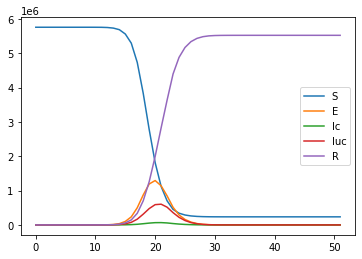

In [67]:
Iuc = 10
sigma = 0.5
beta = 3
gamma = 0.9
f = 0.1

y0 = [N-Iuc,10,0,Iuc,0]  # SEIR
sol = solve_ivp(SEIR,[0,100],y0,args=(beta,sigma,gamma,f))

plt.plot(sol.y[0],label = 'S')
plt.plot(sol.y[1],label = 'E')
plt.plot(sol.y[2],label = 'Ic')
plt.plot(sol.y[3],label = 'Iuc')
plt.plot(sol.y[4],label = 'R')
plt.legend()
         

In [79]:
def positive_check(x):
    # check to ensure all params >= 0
    return np.all(x >= 0)

def solve_ode(params):
    if not positive_check(params):
        return np.zeros(len(time)) + np.inf
    
    Iuc0,E0,beta,sigma,gamma,f = params

    Ic0 = country.confirmed.values[0]

    S0 = N - (Ic0 + Iuc0 + E0)
    R0 = 0
    
    y0 = [S0,E0,Ic0,Iuc0,R0]

    sol = solve_ivp(SEIR,[0,100],y0,args=(beta,sigma,gamma,f),dense_output=True)
    confirmed = np.cumsum(sol.sol(time)[2])

    if positive_check(confirmed):
        return confirmed

    else:
        return np.zeros(len(time)) + np.inf  
    
def sse(params):  # sum of squared errors on log scale
    data = country.confirmed.values.astype('float64')
    model = solve_ode(params)

    errors = (np.log(data+0.1) - np.log(model+0.1))**2
    return np.sum(errors)


def log_like(params):
    data = country.confirmed.values.astype('float64') + 0.1
    model = solve_ode(params) + 0.1
    
    if np.any(model == np.inf):
        return (np.inf)*(-1.0)
    else:
        likehood = stats.norm.logpdf(data, model, np.sqrt(model))  # x, mean, scale
        return np.sum(likehood)


def nll(params):
    return log_like(params) * (-1.0)


def log_prior(params):
    Iuc0,E0,beta,sigma,gamma,f = params
    prior = 0
    
    # typically takes 7 days to recover
    prior += stats.norm.logpdf(b/gamma,3,0.2)
    
    #r0 is approximately 3
    prior += stats.norm.logpdf(gamma,0.14,0.2)
    return prior
    
    
def log_posterior(params):
    return log_prior(params) + log_like(params)

def nlp(params):
    return log_posterior(params) *(-1.0)

def view_plot(params,alpha=0.5,color='black'):
    confirmed = solve_ode(params)
    plt.plot(confirmed, alpha=alpha,color = color)

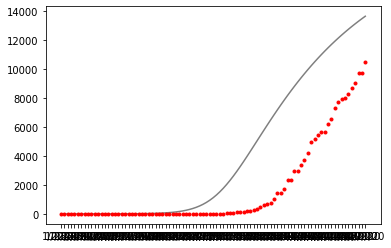

In [80]:
Iuc0 = 300
E0 = 30
b = 0.5
sigma = 0.2
gamma = 0.03
f = 0.0001

view_plot(np.array([Iuc0,E0,b,sigma,gamma,f]))
plt.plot(country.confirmed,'ro',markersize = 3)

MAP r0 7.266580062675505


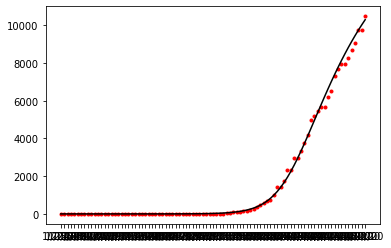

In [81]:
# Minimize negative log likelihood to find MAP

opt = minimize(nlp,[Iuc0,E0,b,sigma,gamma,f],method='Nelder-Mead')
print('MAP r0',opt.x[2]/opt.x[4])

plt.plot(country.confirmed,'ro',markersize = 3)
view_plot(opt.x,alpha=1)



In [82]:
H = nd.Hessian(nll, step=0.00001, method='central', order=2)(opt.x)
cov = np.linalg.inv(H)

p0 = np.random.multivariate_normal(opt.x,cov,size = 15)
p0 = np.abs(p0)
#for i in range(10):
#    p0[i,-1] = np.random.rand()

/Users/kulkarniad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


In [14]:
import emcee

ndim, nwalkers = 6, 15

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like)
output = sampler.run_mcmc(p0,1000,store=True)


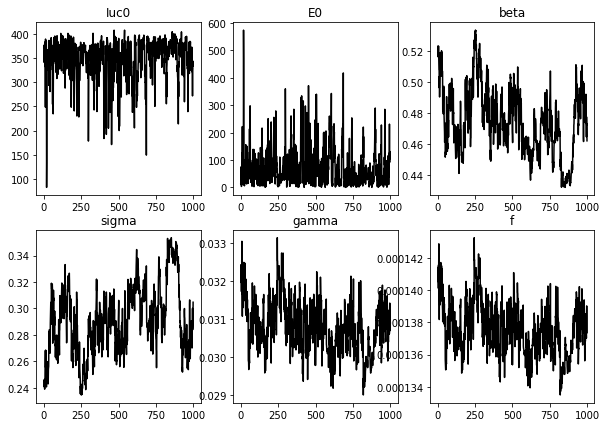

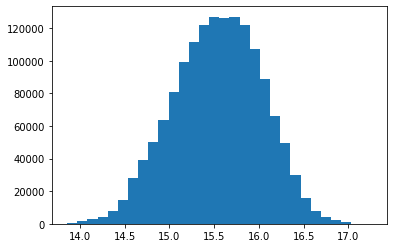

In [22]:
chain = sampler.get_chain()
#Iuc0,E0,beta,sigma,gamma,f
chain = np.load('big_likehood_SEIR.npy')
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.title('Iuc0')
plt.plot(chain[::100,::100,0],color = 'black')
plt.subplot(232)
plt.title('E0')
plt.plot(chain[::100,::100,1],color = 'black')
plt.subplot(233)
plt.title('beta')
plt.plot(chain[::100,::100,2],color = 'black')
plt.subplot(234)
plt.title('sigma')
plt.plot(chain[::100,::100,3],color = 'black')
plt.subplot(235)
plt.title('gamma')
plt.plot(chain[::100,::100,4],color = 'black')
plt.subplot(236)
plt.title('f')
plt.plot(chain[::100,::100,5],color = 'black')
plt.show()


r0 = chain[:,:,2].flatten()/chain[:,:,4].flatten()
plt.hist(r0,bins=30)
plt.show()

#Iuc0,E0,beta,sigma,gamma,f

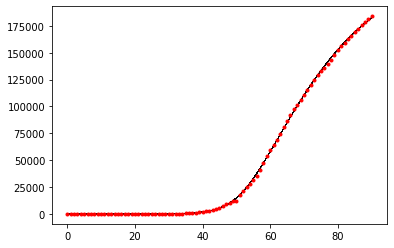

In [16]:
niter, nwalkers, ndim = chain.shape
for i in range(40):
    for n in range(10):
        view_plot(chain[-i,n],alpha = 0.005,color='black')

plt.plot(italy.confirmed.values,'ro',markersize = 3)

